<a href="https://colab.research.google.com/github/sg-peytrignet/GIGA-mapping-training/blob/main/cost_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost analysis

## Setting up our environment

We import Python libraries needed for our cost analysis:

- Data tools (pandas, numpy) for calculations
- Geographic tools (geopandas) for mapping
- Visualization libraries (matplotlib, folium, seaborn) for creating graphs and maps

These will help us analyze and visualize the costs of different connectivity options.

In [20]:
# Data handling
import pandas as pd
import numpy as np

# Graph and spatial libraries
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Notebook interaction and display
import ipywidgets as widgets
from IPython.display import display

The option `display_folium` controls whether to display interactive maps, which can be heavy and prevent the markdown file from displaying correctly.

In [21]:
display_folium = True

## Set analysis parameters

We create an interactive interface to set important cost variables for different connection technologies (Fiber, Cellular, Point-to-Point, and Satellite).

For each technology, we can adjust:

- **CAPEX**: One-time installation costs (equipment, setup)
- **OPEX**: Ongoing yearly costs (maintenance, service fees)
- **ARPU**: Annual Revenue Per User (expected income per person)

We also set the **maximum fiber cable length** per school and **analysis timeframe** in years.

**Estimating Number of Users:**

- In our case, the number of users is the number of pupils and staff who will access the internet at each school.
- First, we count the number of residents living within each school's radius (see figure).
- Then, we multiply the number of residents by the percentage of school-age population.

This gives us our estimated number of users per 100 residents in a radius around each school.

_Table. Number of internet users in Namibia._

| Metric | Value | Source |
|--------|--------|---------|
| Population of School Age (%) | 16.14 | [UNESCO](https://data.uis.unesco.org/index.aspx?queryid=3847) |
| Users per 100 Residents | 16.14 | - |

_Figure. 1km buffers around schools overlaid with population data._

<a href="https://ibb.co/dB09sHB"><img src="https://i.ibb.co/9n9Xmdn/demand-buffers.jpg" alt="demand-buffers" border="0"></a>

**Estimating Annual Revenue per User (ARPU):**

- Start with the monthly cost of an appropriate data bundle.
- Multiply by the number of school months.

A note about operator revenues:

- We use mobile internet costs as our baseline.
- This is because mobile cost data *per user* is widely available.
- We assume other technologies (like fiber) would have similar revenue per user.

_Table. Operator revenues in Namibia._

| Metric | Value | Source |
|--------|--------|---------|
| Monthly Cost of 15GB Data (USD) | 25.00 | [Mobile Telecommunications Company (MTC)](https://mtc.com.na/contract/databundle/1506) |
| School Year Duration (months) | 9.00 | Education System Data |
| Annual Revenue Per User (USD) | 225 |  |

In [22]:
# @title Cost parameters
# Common layout for all widgets
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Parameters for each technology
technologies = ['fiber', 'p2area', 'p2p', 'satellite']
tech_controls = {}
for tech in technologies:
    tech_controls[tech] = {
        'CAPEX': widgets.FloatSlider(
            description='One-off CAPEX (USD):',
            min=0,
            max=10000,
            step=1,
            value=1000,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'
        ),
        'OPEX': widgets.FloatSlider(
            description=f'Annual OPEX (USD):',
            min=0,
            max=5000,
            step=1,
            value=500,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'
        ),
        'ARPU': widgets.FloatSlider(
            description=f'Annual revenue per user (USD):',
            min=0,
            max=500,
            step=1,
            value=225,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'
        )
    }

    # Add max fiber length parameter only to Fiber technology
    if tech == 'fiber':
        tech_controls[tech]['max_length'] = widgets.FloatSlider(
            description='Maximum Fiber Length (km):',
            min=0,
            max=50,
            step=1,
            value=25,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'
        )

num_years = widgets.IntSlider(
    description='Number of years:',
    min=1,
    max=50,
    step=1,
    value=10,
    layout=item_layout,
    style={'description_width': 'initial'},
    readout_format=',.0f'
)

users_per_pop = widgets.FloatSlider(
    description='Users per 100 residents:',
    min=0,
    max=100,
    step=1,
    value=16,  # Setting default to the value from earlier
    layout=item_layout,
    style={'description_width': 'initial'},
    readout_format=',.3f'
)

# Arrange controls in a layout
tech_layouts = []
for tech, controls in tech_controls.items():
    tech_layouts.append(
        widgets.VBox(
            [widgets.HTML(value=f"<b>{tech.capitalize()}</b>")] +
            [controls[param] for param in controls],
            layout=widgets.Layout(justify_content='space-between')
        )
    )

overall_layout = widgets.VBox(
    [widgets.HTML(value='<b>Overall Parameters</b>'), num_years, users_per_pop],
    layout=widgets.Layout(justify_content='space-between')
)

inputs_layout = widgets.VBox(
    children= [overall_layout] + tech_layouts
)

# Satellite (High costs)
tech_controls['satellite']['CAPEX'].value = 8000  # High one-time cost
tech_controls['satellite']['OPEX'].value = 4000   # High annual maintenance

# P2P and Cellular (Low costs)
tech_controls['p2p']['CAPEX'].value = 2000
tech_controls['p2p']['OPEX'].value = 800

tech_controls['p2area']['CAPEX'].value = 1500   # Slightly cheaper than P2P
tech_controls['p2area']['OPEX'].value = 600     # Slightly cheaper than P2P

# Fiber (Medium costs)
tech_controls['fiber']['CAPEX'].value = 4000      # Medium one-time cost
tech_controls['fiber']['OPEX'].value = 2000       # Medium annual maintenance

display(inputs_layout)

## Get results from previous analyses

We load our previously calculated analysis results:

- **Proximity data**: distances to existing infrastructure
- **Coverage data**: which areas have cellular service
- **Demand data**: number of potential users near each school
- **Visibility data**: line-of-sight between schools and towers
- **Fiber path data**: distance between schools and fiber nodes

This gives us the foundation for our revenue and cost calculations.

### Merged results

In [23]:
merged_results = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/namibia/merged_namibia.geojson")
merged_results = merged_results.set_index("school_id")

In [24]:
merged_results.head()

,cell_site_distance,fiber_node_distance,coverage,population_1km,visible,geometry
school_id,,,,,,
1,223505.892325,392.462504,True,2643.301395,False,POINT (16.86548 -24.62704)
2,789.912802,209.967957,True,4623.873197,True,POINT (17.07466 -22.59953)
3,141006.662606,2178.090670,False,53.916444,False,POINT (16.0606 -20.15091)
4,542.425612,319.117857,True,83.437086,True,POINT (17.06546 -22.54665)
5,107.142936,83.408131,True,270.790799,True,POINT (17.10974 -22.57598)


## Assess feasibility of technologies for each school

We determine which connection technologies are possible for each school based on:

- **Fiber**: Is it close enough to existing fiber networks?
- **Cellular**: Is it in an area with coverage?
- **Point-to-Point**: Does it have line-of-sight to towers?
- **Satellite**: Always feasible, but often more expensive.

This helps eliminate impossible options before cost analysis.

In [25]:
feasibility = merged_results.copy()
feasibility["fiber_feasible"] = feasibility["fiber_node_distance"] <= tech_controls['fiber']['max_length'].value*1000
feasibility["p2area_feasible"] = feasibility["coverage"]
feasibility["p2p_feasible"] = feasibility["visible"]
feasibility["satellite_feasible"] = True
feasibility = feasibility[["fiber_feasible","p2area_feasible","p2p_feasible","satellite_feasible"]]

In [26]:
feasibility.head()

,fiber_feasible,p2area_feasible,p2p_feasible,satellite_feasible
school_id,,,,
1,True,True,False,True
2,True,True,True,True
3,True,False,False,True
4,True,True,True,True
5,True,True,True,True


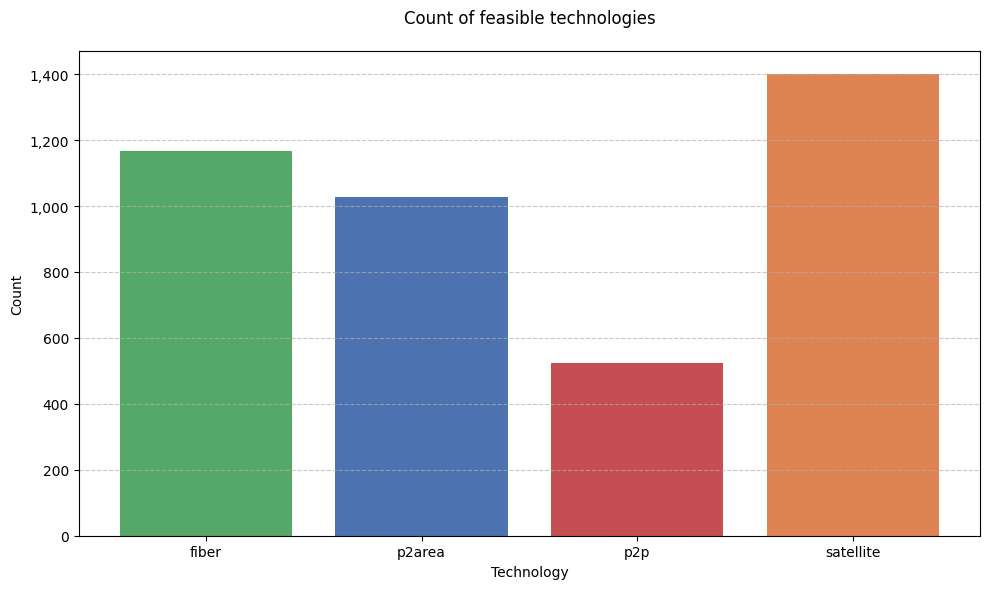

In [27]:
# @title Figure: Technology Feasibility
# Create feasibility counts for bar chart
feasibility_counts = {
   'fiber': feasibility['fiber_feasible'].sum(),
   'p2area': feasibility['p2area_feasible'].sum(),
   'p2p': feasibility['p2p_feasible'].sum(),
   'satellite': feasibility['satellite_feasible'].sum()
}
color_map = {
   'p2area': '#4C72B0',
   'satellite': '#DD8452',
   'fiber': '#55A868',
   'p2p': '#C44E52'
}
plt.figure(figsize=(10, 6))
technologies = list(feasibility_counts.keys())
counts = list(feasibility_counts.values())
colors = [color_map[tech] for tech in technologies]
plt.bar(technologies, counts, color=colors)
plt.title('Count of feasible technologies', pad=20)
plt.xlabel('Technology')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

## Compute operator revenues for each school and technology

For each feasible technology at each school, we calculate the potential revenue. This shows which technologies might be profitable for service providers - as summarised in the figure below.

_Figure. Net revenue._

<a href="https://ibb.co/3sy1qTr"><img src="https://i.ibb.co/LPzSW0k/net-revenues.jpg" alt="net-revenues" border="0"></a>

In [28]:
net_revenues = merged_results.copy()

# Shared parameters
years = num_years.value
user_ratio = users_per_pop.value / 100
population = merged_results["population_1km"]

# Fiber revenue calculation
fiber_annual_revenue = tech_controls["fiber"]["ARPU"].value * population * user_ratio
fiber_total_costs = tech_controls["fiber"]["CAPEX"].value + (tech_controls["fiber"]["OPEX"].value * years)
net_revenues["fiber_net_revenue"] = (fiber_annual_revenue * years) - fiber_total_costs

# Cellular (p2area) revenue calculation
cellular_annual_revenue = tech_controls["p2area"]["ARPU"].value * population * user_ratio
cellular_total_costs = tech_controls["p2area"]["CAPEX"].value + (tech_controls["p2area"]["OPEX"].value * years)
net_revenues["p2area_net_revenue"] = (cellular_annual_revenue * years) - cellular_total_costs

# P2P revenue calculation
p2p_annual_revenue = tech_controls["p2p"]["ARPU"].value * population * user_ratio
p2p_total_costs = tech_controls["p2p"]["CAPEX"].value + (tech_controls["p2p"]["OPEX"].value * years)
net_revenues["p2p_net_revenue"] = (p2p_annual_revenue * years) - p2p_total_costs

# Satellite revenue calculation
satellite_annual_revenue = tech_controls["satellite"]["ARPU"].value * population * user_ratio
satellite_total_costs = tech_controls["satellite"]["CAPEX"].value + (tech_controls["satellite"]["OPEX"].value * years)
net_revenues["satellite_net_revenue"] = (satellite_annual_revenue * years) - satellite_total_costs

# Keep only revenue columns
net_revenues = net_revenues[["fiber_net_revenue", "p2area_net_revenue", "p2p_net_revenue", "satellite_net_revenue"]]

# Total cost dataframe
costs = pd.DataFrame({
    'technology': ['fiber', 'p2area', 'p2p', 'satellite'],
    'total_cost': [fiber_total_costs, cellular_total_costs, p2p_total_costs, satellite_total_costs]
})
costs["annual_cost"] = costs["total_cost"] / years

In [29]:
# Set cost to missing if technology is not feasible
for tech in ['fiber', 'p2area', 'p2p', 'satellite']:
    net_revenues.loc[~feasibility[f'{tech}_feasible'], f'{tech}_net_revenue'] = np.nan

First, we compare the annual costs (CAPEX and OPEX) for the different technologies.

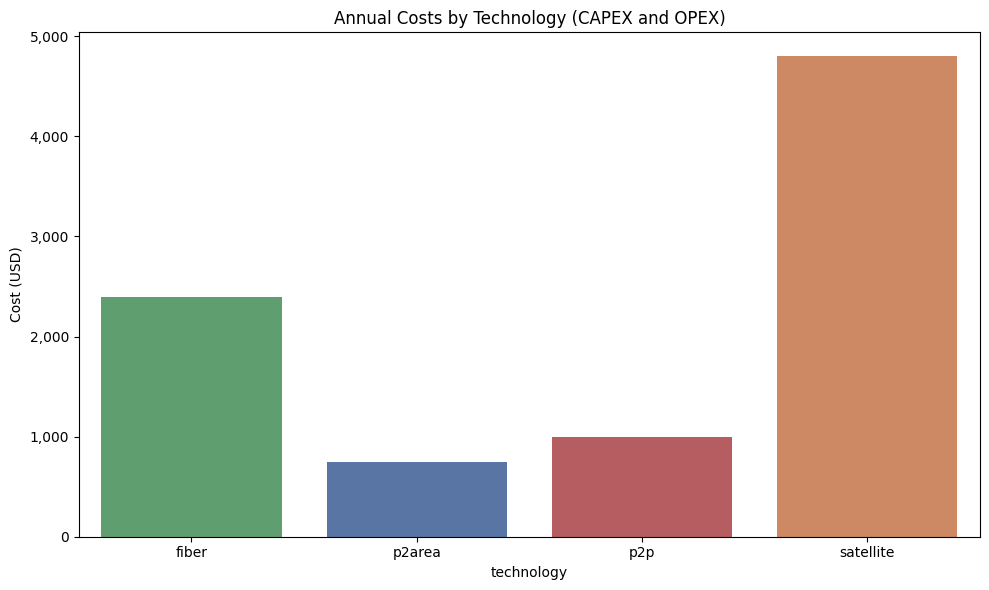

In [30]:
# @title Figure: annual costs per school
# Calculate total cost per school for each technology

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=costs,
            x='technology',
            y='annual_cost',
            hue='technology',
            legend=False,
            palette=color_map)

plt.title(f'Annual Costs by Technology (CAPEX and OPEX)')
plt.ylabel('Cost (USD)')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

Then, we compare the revenues associated with each school and technology pair. In this chart below, each dot represents a school. Within each technology, schools with a higher number of users have a higher revenue and schools where the technology is not feasible do not appear in the chart.

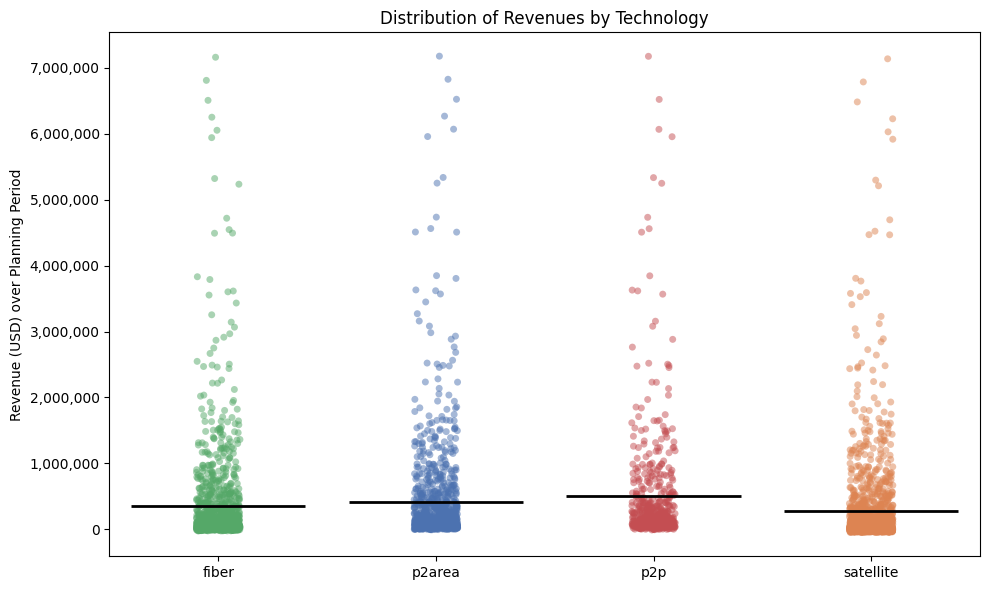

In [31]:
# @title Figure: Revenues by Technology
# Box plot of revenues by technology
data = net_revenues[['fiber_net_revenue', 'p2area_net_revenue', 'p2p_net_revenue', 'satellite_net_revenue']].melt(
   var_name='Technology',
   value_name='Revenue'
)
data['Technology'] = data['Technology'].str.replace('_net_revenue', '')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Technology', y='Revenue', data=data, palette=color_map, hue='Technology',
            showfliers=False, showbox=False, showcaps=False, showmeans=True, meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10)

sns.stripplot(x='Technology', y='Revenue', data=data, alpha=0.5, jitter=True, palette=color_map, hue='Technology')
plt.xlabel('')
plt.ylabel('Revenue (USD) over Planning Period')
plt.title('Distribution of Revenues by Technology')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

## Assign a technology to each school by maximizing operator revenue

We assign the best technology for each school by:

1. Considering **only feasible** options.
2. Among the feasible options, selecting the technology with **highest net revenue**.
3. Marking schools where no options exist.

This helps identify the most economically viable connection method for each school.

In [32]:
# Find highest revenue for each row
revenue_cols = ['fiber_net_revenue', 'p2area_net_revenue', 'p2p_net_revenue', 'satellite_net_revenue']
net_revenues['technology'] = net_revenues[revenue_cols].idxmax(axis=1).str.replace('_net_revenue', '')

# If all revenues are NaN, set selected_technology to NaN
mask = net_revenues[revenue_cols].isna().all(axis=1)
net_revenues.loc[mask, 'technology'] = np.nan

# Merge costs
net_revenues = pd.merge(net_revenues.reset_index(), costs, on='technology', how='left').set_index("school_id")

In [33]:
net_revenues.head()

,fiber_net_revenue,p2area_net_revenue,p2p_net_revenue,satellite_net_revenue,technology,total_cost,annual_cost
school_id,,,,,,,
1,9.275885e+05,9.440885e+05,NaN,9.035885e+05,p2area,7500.0,750.0
2,1.640594e+06,1.657094e+06,1.654594e+06,1.616594e+06,p2area,7500.0,750.0
3,-4.590080e+03,NaN,NaN,-2.859008e+04,fiber,24000.0,2400.0
4,6.037351e+03,2.253735e+04,2.003735e+04,-1.796265e+04,p2area,7500.0,750.0
5,7.348469e+04,8.998469e+04,8.748469e+04,4.948469e+04,p2area,7500.0,750.0


## Visualize the technology assignment

We create two main visualizations:

1. **Bar Chart**: Shows how many schools are assigned to each technology
2. **Interactive Map**: Displays schools color-coded by their assigned technology

### Bar chart

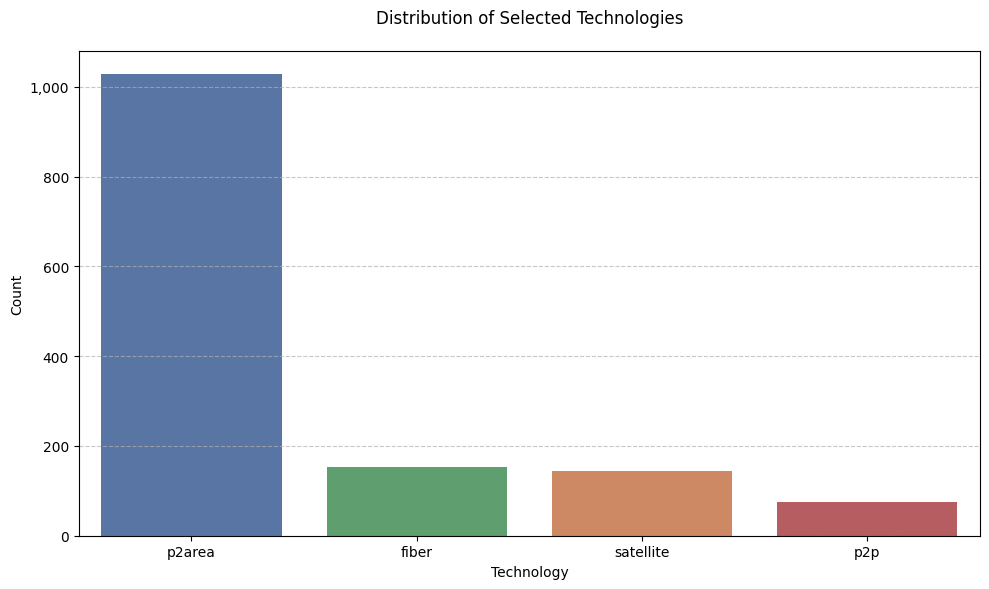

In [34]:
# @title Figure: Distribution of Selected Technologies
plt.figure(figsize=(10, 6))
sns.barplot(data=net_revenues["technology"].value_counts().reset_index(),
           x="technology",
           y="count",
           palette=color_map,
           hue="technology")
plt.title('Distribution of Selected Technologies', pad=20)
plt.xlabel('Technology')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

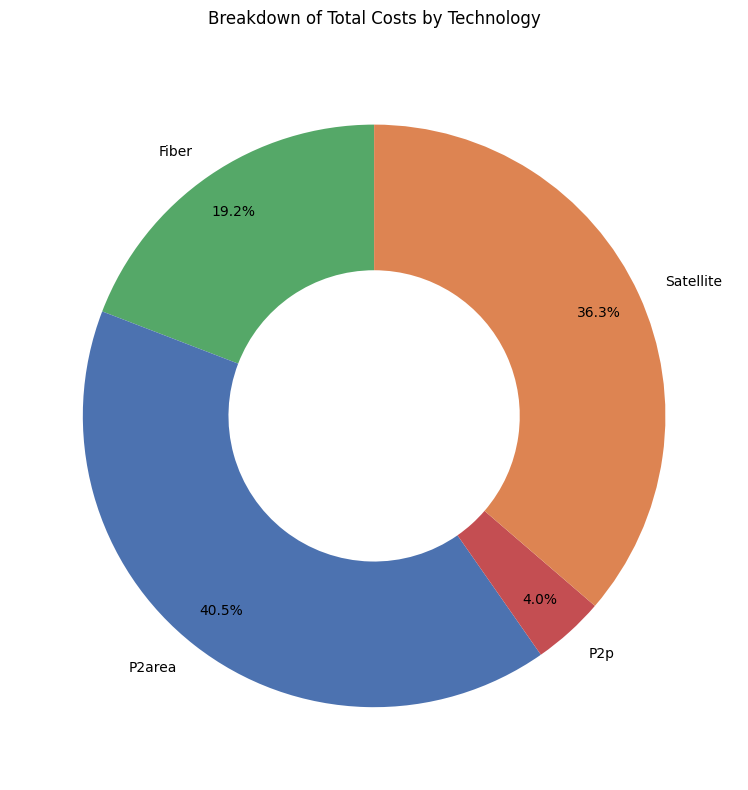

In [35]:
# @title Figure: Breakdown of Total Costs
plt.figure(figsize=(10, 8))
cost_data = net_revenues.groupby("technology")["total_cost"].sum()
plt.pie(cost_data,
        labels=[tech.capitalize() for tech in cost_data.index],
        colors=[color_map[tech] for tech in cost_data.index],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        wedgeprops=dict(width=0.5))
plt.title('Breakdown of Total Costs by Technology', pad=20)
plt.tight_layout()

### Map

In [36]:
# @title Figure: Interactive Map
def plot_points_by_technology(points_gdf, color_map, title="Points by Technology", zoom=6):
    """
    Create an interactive map with points colored by selected technology
    """
    if points_gdf.crs != "EPSG:4326":
        points_gdf = points_gdf.to_crs("EPSG:4326")

    center_lat = points_gdf.geometry.y.mean()
    center_lon = points_gdf.geometry.x.mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

    title_html = f'''
    <div style="position: fixed;
                top: 10px;
                left: 50px;
                z-index: 1000;
                background-color: white;
                padding: 10px;
                border-radius: 5px;">
        <h4>{title}</h4>
        Total Points: {len(points_gdf)}
    </div>
    '''

    legend_html = '''
    <div style="position: fixed;
                bottom: 50px;
                right: 50px;
                z-index: 1000;
                background-color: white;
                padding: 10px;
                border-radius: 5px;">
    <p><strong>Technologies</strong></p>
    '''

    for tech, color in color_map.items():
        legend_html += f'<p><span style="color:{color}">●</span> {tech}</p>'

    legend_html += '</div>'

    m.get_root().html.add_child(folium.Element(title_html))
    m.get_root().html.add_child(folium.Element(legend_html))

    for _, row in points_gdf.iterrows():
        color = color_map.get(row.technology, '#808080')  # gray for NaN
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"ID: {row.name}<br>Technology: {row.technology}"
        ).add_to(m)

    return m

In [37]:
technology_selection = merged_results.merge(net_revenues["technology"], left_index=True, right_index=True).dropna(subset=["technology"])

In [38]:
if display_folium:
  m = plot_points_by_technology(technology_selection, color_map, title="Schools by Selected Technology", zoom=6)
  display(m)